In [67]:
import dataset as dt
import visualize as vl
import features as ft

import math
import numpy as np
import pandas as pd
from scipy import stats
import librosa

from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
plt.style.use('ggplot')

sns.set_theme(style="white")
random_state = 101
np.random.seed(random_state)
cv = 10

In [2]:
df = dt.read_dataset()

In [3]:
df.shape

(1000, 27)

In [4]:
df.head()

,chromagram,rms,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,genre
1,0.350088,0.130228,1784.165850,2002.449060,3805.839606,0.083045,-113.570650,121.571790,-19.168142,42.366420,...,8.803792,-3.672300,5.747995,-5.162882,0.752740,-1.690215,-0.408979,-2.303523,1.221290,blues
2,0.340914,0.095948,1530.176679,2039.036516,3550.522098,0.056040,-207.501700,123.991264,8.955127,35.877647,...,5.376328,-2.231760,4.220140,-6.012148,0.927997,-0.731125,0.295073,-0.283518,0.531216,blues
3,0.363637,0.175570,1552.811865,1747.702312,3042.260232,0.076291,-90.722595,140.446300,-29.093890,31.684334,...,5.791199,-8.907628,-1.077000,-9.229274,2.451689,-7.729094,-1.816407,-3.439720,-2.231259,blues
4,0.404785,0.141093,1070.106615,1596.412872,2184.745799,0.033309,-199.544200,150.090900,5.662678,26.859080,...,6.079319,-2.480174,-1.079305,-2.870789,0.780873,-3.319596,0.636965,-0.619121,-3.407449,blues
5,0.308526,0.091529,1835.004266,1748.172116,3579.757627,0.101461,-160.337700,126.219635,-35.587810,22.148071,...,-2.813867,-6.933385,-7.552725,-9.164666,-4.520575,-5.454034,-0.916874,-4.404826,-11.703234,blues


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   chromagram  1000 non-null   float64
 1   rms         1000 non-null   float64
 2   spec_cent   1000 non-null   float64
 3   spec_bw     1000 non-null   float64
 4   rolloff     1000 non-null   float64
 5   zcr         1000 non-null   float64
 6   mfcc0       1000 non-null   float64
 7   mfcc1       1000 non-null   float64
 8   mfcc2       1000 non-null   float64
 9   mfcc3       1000 non-null   float64
 10  mfcc4       1000 non-null   float64
 11  mfcc5       1000 non-null   float64
 12  mfcc6       1000 non-null   float64
 13  mfcc7       1000 non-null   float64
 14  mfcc8       1000 non-null   float64
 15  mfcc9       1000 non-null   float64
 16  mfcc10      1000 non-null   float64
 17  mfcc11      1000 non-null   float64
 18  mfcc12      1000 non-null   float64
 19  mfcc13      1000 non-null  

In [6]:
dt.remove_duplicates(df, same_label=False, inplace=True)

,chromagram,rms,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,mfcc2,mfcc3,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,genre
1,0.350088,0.130228,1784.165850,2002.449060,3805.839606,0.083045,-113.570650,121.571790,-19.168142,42.366420,...,8.803792,-3.672300,5.747995,-5.162882,0.752740,-1.690215,-0.408979,-2.303523,1.221290,blues
2,0.340914,0.095948,1530.176679,2039.036516,3550.522098,0.056040,-207.501700,123.991264,8.955127,35.877647,...,5.376328,-2.231760,4.220140,-6.012148,0.927997,-0.731125,0.295073,-0.283518,0.531216,blues
3,0.363637,0.175570,1552.811865,1747.702312,3042.260232,0.076291,-90.722595,140.446300,-29.093890,31.684334,...,5.791199,-8.907628,-1.077000,-9.229274,2.451689,-7.729094,-1.816407,-3.439720,-2.231259,blues
4,0.404785,0.141093,1070.106615,1596.412872,2184.745799,0.033309,-199.544200,150.090900,5.662678,26.859080,...,6.079319,-2.480174,-1.079305,-2.870789,0.780873,-3.319596,0.636965,-0.619121,-3.407449,blues
5,0.308526,0.091529,1835.004266,1748.172116,3579.757627,0.101461,-160.337700,126.219635,-35.587810,22.148071,...,-2.813867,-6.933385,-7.552725,-9.164666,-4.520575,-5.454034,-0.916874,-4.404826,-11.703234,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.352063,0.079486,2008.149458,2106.541053,4253.557033,0.089227,-153.640960,109.864650,-23.065697,59.050125,...,12.348828,-12.297895,5.777902,-10.273881,1.789867,-13.289984,2.484145,-6.713265,-1.193787,rock
997,0.398687,0.076458,2006.843354,2068.942009,4149.338328,0.097664,-142.392030,116.189630,-32.147167,49.117840,...,14.080058,-16.392994,4.154395,-4.364872,3.739020,-10.848310,1.881228,-7.461491,-2.795339,rock
998,0.432142,0.081651,2077.526598,1927.293153,4031.405321,0.121823,-124.952270,115.177155,-47.975150,52.814674,...,10.474113,-17.947060,1.212127,-11.519417,1.838090,-12.845291,3.440978,-12.588070,-2.106337,rock
999,0.362485,0.083860,1398.699344,1818.450280,3015.631004,0.048724,-225.007750,123.646770,-9.724175,56.605164,...,7.682845,-10.070732,-0.256386,-5.275369,-2.812177,-4.416050,1.556207,-5.041897,-3.590644,rock


In [7]:
genre_count = df.groupby('genre').count()
genre_count.iloc[:, 0]

genre
blues        100
classical    100
country      100
disco         99
hiphop        98
jazz         100
metal         92
pop           98
reggae        99
rock          99
Name: chromagram, dtype: int64

In [8]:
display(df.describe().round(2))

,chromagram,rms,spec_cent,spec_bw,rolloff,zcr,mfcc0,mfcc1,mfcc2,mfcc3,...,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
count,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.00,...,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.00,985.00
mean,0.38,0.13,2194.40,2239.71,4558.77,0.10,-145.38,99.81,-8.72,36.24,...,-5.97,4.41,-4.71,1.76,-3.85,1.10,-3.93,0.47,-2.29,-1.11
std,0.08,0.07,716.93,527.25,1578.03,0.04,100.62,31.42,21.50,16.66,...,6.79,6.72,6.08,5.02,4.87,4.57,4.54,3.87,3.72,3.85
min,0.17,0.01,570.04,898.07,749.14,0.02,-552.12,-1.46,-89.87,-18.73,...,-28.06,-15.80,-27.52,-12.59,-17.54,-15.69,-17.23,-11.96,-18.50,-19.93
25%,0.32,0.09,1615.94,1899.19,3362.19,0.07,-202.06,76.78,-23.83,24.12,...,-10.81,-0.58,-9.26,-1.66,-7.11,-1.88,-7.14,-2.04,-4.60,-3.39
50%,0.38,0.12,2192.65,2218.68,4615.98,0.10,-121.14,98.66,-10.66,36.83,...,-5.89,3.84,-4.13,1.88,-3.58,1.17,-4.04,0.65,-2.38,-1.19
75%,0.43,0.18,2685.53,2576.47,5534.64,0.13,-74.06,120.29,5.61,47.98,...,-1.03,9.58,-0.15,5.14,-0.31,4.30,-0.83,3.07,0.18,1.30
max,0.66,0.40,4435.24,3509.65,8677.67,0.27,42.04,193.10,56.68,80.70,...,17.42,23.03,13.05,18.18,12.36,13.46,11.48,15.39,14.69,15.37


In [9]:
# Skewness measures the symmetry of the distribution
# skewness between -0.5 and 0.5 -> the data are fairly symmetrical
# skewness between -1 and  -0.5 or between 0.5 and 1 -> the data are moderately skewed
# skewness less than -1 or greater than 1 -> the data are highly skewed
df.skew(axis=0, numeric_only=True)

chromagram   -0.014797
rms           0.443598
spec_cent     0.246645
spec_bw       0.101700
rolloff       0.122530
zcr           0.567790
mfcc0        -1.001532
mfcc1         0.253905
mfcc2         0.279501
mfcc3         0.025488
mfcc4        -0.211812
mfcc5        -0.054787
mfcc6         0.042610
mfcc7        -0.017820
mfcc8         0.033529
mfcc9        -0.009325
mfcc10       -0.140464
mfcc11        0.067330
mfcc12       -0.238859
mfcc13       -0.032204
mfcc14       -0.115915
mfcc15       -0.249302
mfcc16        0.140106
mfcc17       -0.003676
mfcc18        0.039581
mfcc19       -0.274902
dtype: float64

In [10]:
# Fisher’s definition of Kurtosis.
# Kurtosis determines the heaviness of the distribution tails
# kurtosis = 0 -> normal distribution
# kurtosis > 0 -> sharper peak and heavier tails compared to a normal distribution
#               (fewer data values located near the center and more data values that are spread out along the tails)
# kurtosis < 0 -> flatter peak and thinner tails compared to a normal distribution
#               (more data values located near the center and less data values in the tails)
df.kurtosis(axis=0, numeric_only=True)

chromagram   -0.322605
rms          -0.117213
spec_cent    -0.433554
spec_bw      -0.442866
rolloff      -0.473563
zcr           0.064913
mfcc0         0.977505
mfcc1        -0.205709
mfcc2        -0.094163
mfcc3        -0.397039
mfcc4        -0.273843
mfcc5        -0.708001
mfcc6        -0.763563
mfcc7        -0.516002
mfcc8        -0.557575
mfcc9        -0.801357
mfcc10       -0.225266
mfcc11       -0.531170
mfcc12       -0.300971
mfcc13       -0.153715
mfcc14       -0.120889
mfcc15        0.416459
mfcc16        0.047514
mfcc17        0.442655
mfcc18        1.207885
mfcc19        2.093001
dtype: float64

In [11]:
# fig, ax = plt.subplots(len(df.columns), 2, figsize=(25, 40))
# for i, column in enumerate(df.columns, 0):
#     if column != 'genre':
#         sns.boxplot(x=df[column], ax=ax[i,0])
#         sns.histplot(x=df[column], kde=True, ax=ax[i,1])
# plt.tight_layout()

In [12]:
# Multivariate Normality Test
# p <= alpha =>  The data do not follow a normal distribution (Reject H0 hypothesis)
alpha = 0.05
pg.multivariate_normality(df[df.columns[0:-1]], alpha=alpha)

HZResults(hz=1.0682626911461903, pval=0.0, normal=False)

In [13]:
# Univariate Normality Test
k2, p = stats.normaltest(df[df.columns[0:-1]])
print("H0: the data follows a normal distribution\n")
for feature, p in zip(df.columns[0:-1], p):
    print(f'pVal: {p.round(3)}\t - H0 can be rejected: {p<alpha}\t <= {feature}')

H0: the data follows a normal distribution

pVal: 0.053	 - H0 can be rejected: False	 <= chromagram
pVal: 0.0	 - H0 can be rejected: True	 <= rms
pVal: 0.0	 - H0 can be rejected: True	 <= spec_cent
pVal: 0.001	 - H0 can be rejected: True	 <= spec_bw
pVal: 0.0	 - H0 can be rejected: True	 <= rolloff
pVal: 0.0	 - H0 can be rejected: True	 <= zcr
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc0
pVal: 0.002	 - H0 can be rejected: True	 <= mfcc1
pVal: 0.002	 - H0 can be rejected: True	 <= mfcc2
pVal: 0.007	 - H0 can be rejected: True	 <= mfcc3
pVal: 0.004	 - H0 can be rejected: True	 <= mfcc4
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc5
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc6
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc7
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc8
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc9
pVal: 0.058	 - H0 can be rejected: False	 <= mfcc10
pVal: 0.0	 - H0 can be rejected: True	 <= mfcc11
pVal: 0.001	 - H0 can be rejected: True	 <= mfcc12
pVal: 0.555	 -

In [14]:
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.pairplot(df, diag_kind='kde', corner=True)

Class= blues, n= 100 (10.15%)
Class= classical, n= 100 (10.15%)
Class= country, n= 100 (10.15%)
Class= disco, n= 99 (10.05%)
Class= hiphop, n= 98 (9.95%)
Class= jazz, n= 100 (10.15%)
Class= metal, n= 92 (9.34%)
Class= pop, n= 98 (9.95%)
Class= reggae, n= 99 (10.05%)
Class= rock, n= 99 (10.05%)


<BarContainer object of 10 artists>

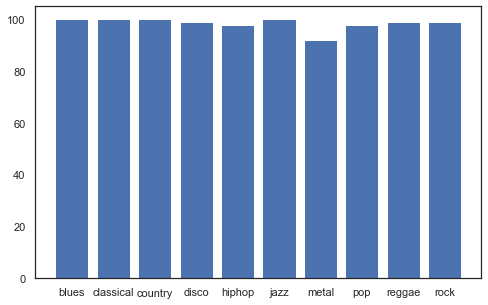

In [15]:
# Initialize Features and Target
X, y = dt.extract_features_and_label(df)

# view class imbalance in full dataset
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print(f'Class= {k}, n= {v} ({per:.2f}%)')

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(counter.keys(), counter.values())

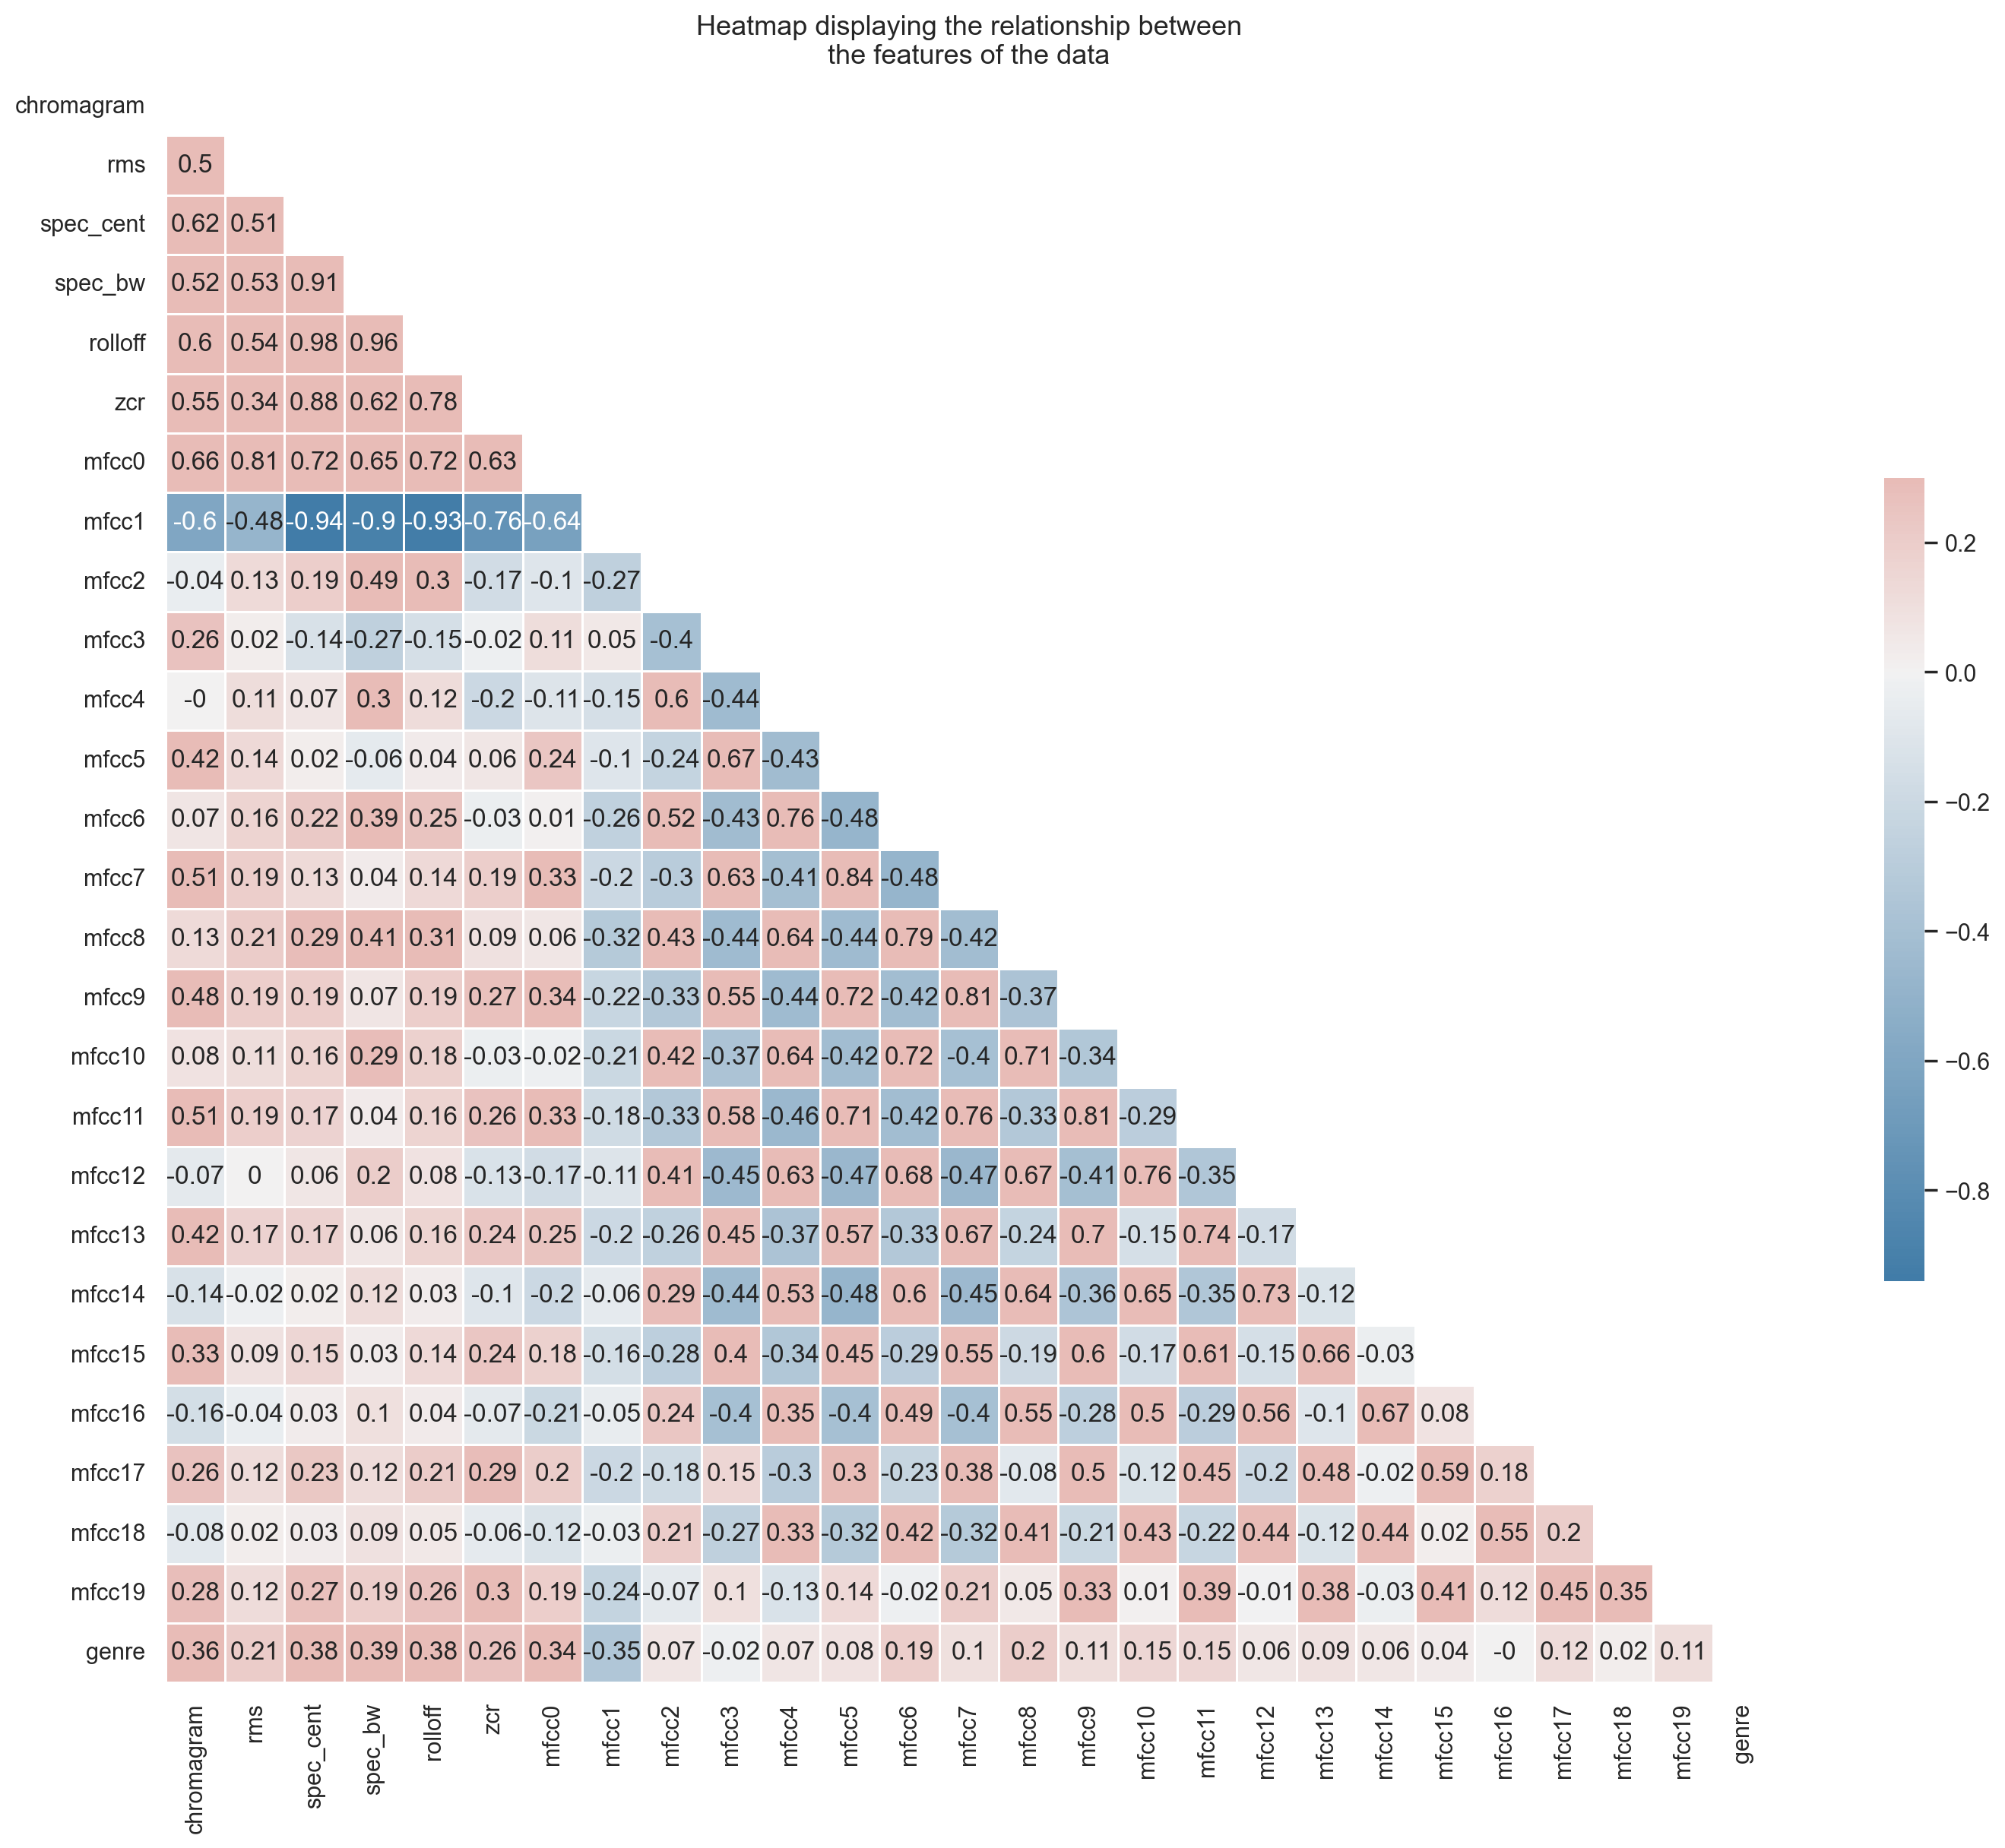

In [16]:
le = LabelEncoder()
df['genre'] = le.fit_transform(df['genre'])
vl.plot_correlation_matrix(df)

In [17]:
# Establish Train/Validation-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

In [18]:
clf = DummyClassifier()
clf.fit(X_train, y_train)
print('Accuracy: %.4f' % clf.score(X_test, y_test))

Accuracy: 0.1014


In [19]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())])
pipe.fit(X_train, y_train)
knn_preds = pipe.predict(X_test)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6047


In [20]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000))])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6486


In [21]:
clf = DecisionTreeClassifier(random_state=random_state)
clf.fit(X_train, y_train)
print('Accuracy: %.4f' % clf.score(X_test, y_test))

Accuracy: 0.4764


In [22]:
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train, y_train)
print('Accuracy: %.4f' % clf.score(X_test, y_test))

Accuracy: 0.6216


In [23]:
clf = GradientBoostingClassifier(random_state=random_state)
clf.fit(X_train, y_train)
print('Accuracy: %.4f' % clf.score(X_test, y_test))

Accuracy: 0.6385


In [24]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6486


In [25]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LinearSVC(max_iter=10000))])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6216


In [26]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', NuSVC())])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6318


(985, 23)


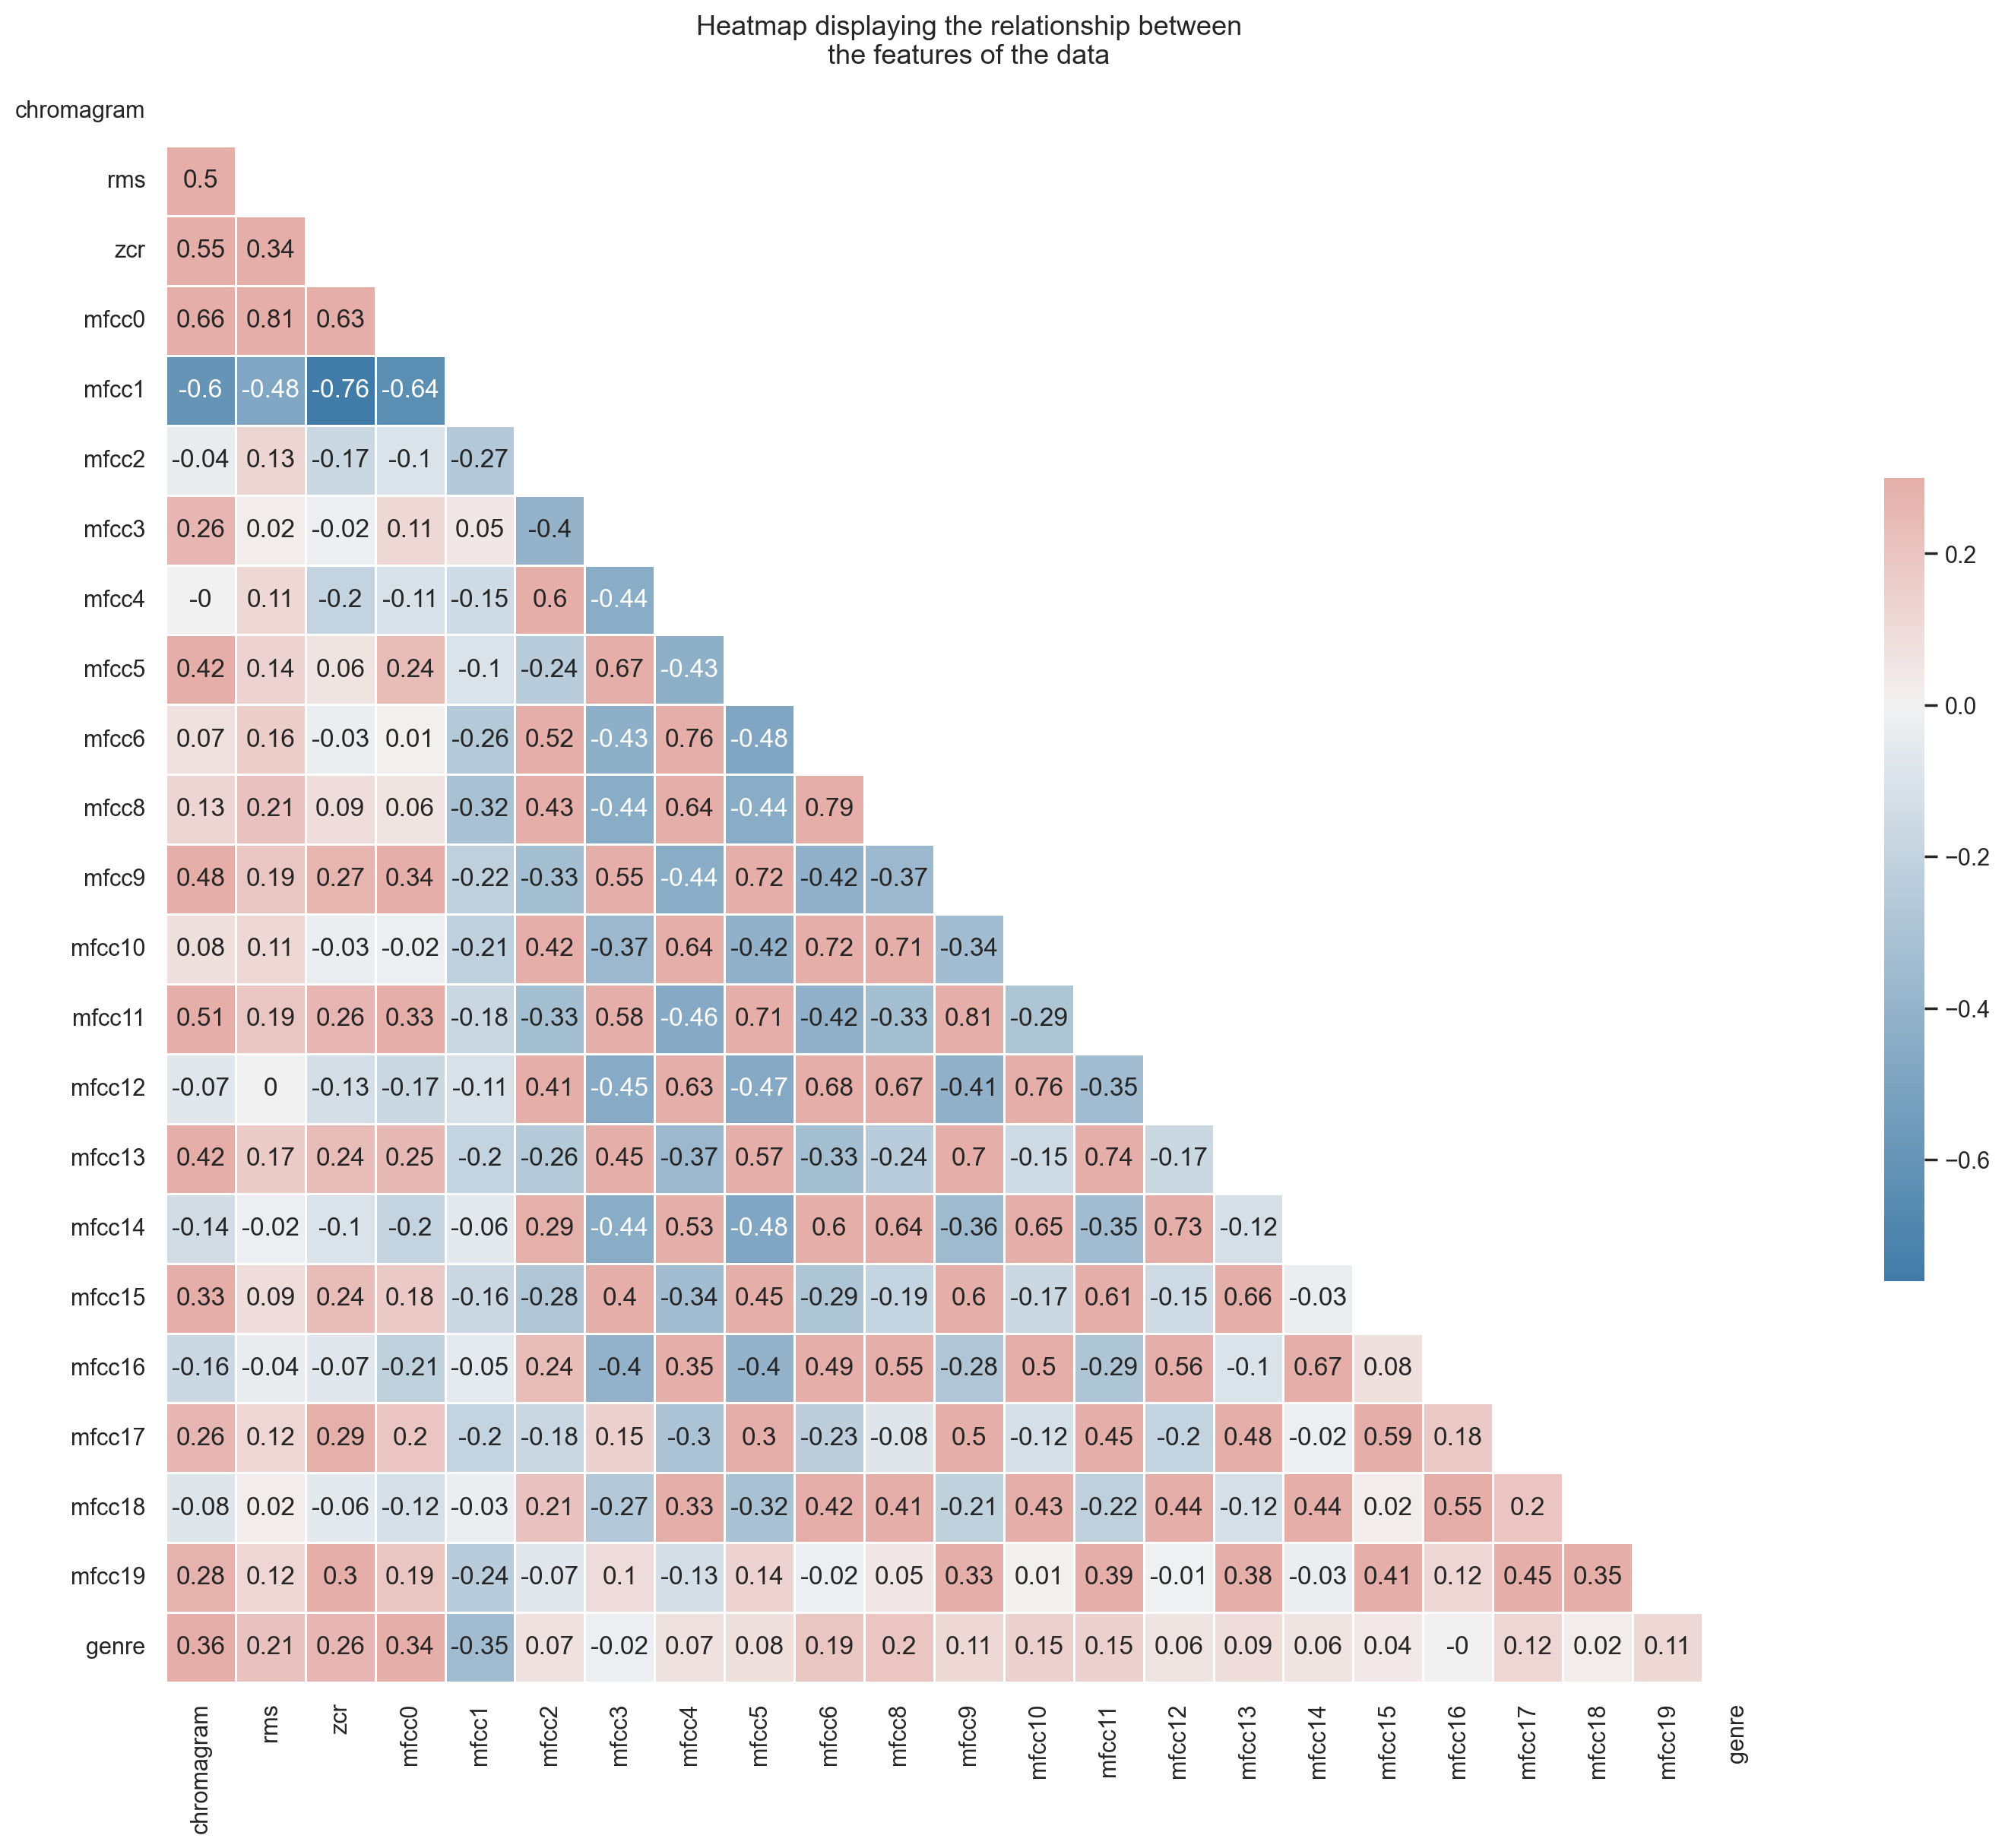

In [27]:
red_df = df.drop(columns=['spec_cent', 'spec_bw', 'rolloff', 'mfcc7'])
print(red_df.shape)
vl.plot_correlation_matrix(red_df)

In [28]:
# Initialize Features and Target
X, y = dt.extract_features_and_label(red_df)

In [29]:
# Establish Train/Validation-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

In [30]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6453


In [31]:
clf = GradientBoostingClassifier(random_state=random_state)
clf.fit(X_train, y_train)
print('Accuracy: %.4f' % clf.score(X_test, y_test))

Accuracy: 0.6723


In [32]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', SVC())])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6622


In [33]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', NuSVC())])
pipe.fit(X_train, y_train)
print('Accuracy: %.4f' % pipe.score(X_test, y_test))

Accuracy: 0.6486


In [34]:
params = {'clf__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
          'clf__C': [0.01, 0.1, 1, 10, 100]
}
pipe = Pipeline([
  ('scale', StandardScaler()),
  ('clf', LogisticRegression(max_iter=1000))
])
grid = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)
print('Best avg score over validation set: %.4f' % grid.best_score_)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print(f'{grid.best_params_}')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best avg score over validation set: 0.6009
Accuracy: 0.6351
{'clf__C': 10, 'clf__solver': 'sag'}


In [35]:
#Accuracy: 0.5676
#{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}

params = {"loss":["deviance"],
          "learning_rate": [0.01, 0.1, 0.2],
          "max_depth": [3, 8],
          "subsample": [0.5, 1.0],
          "max_features": ['sqrt', 'log2'],
          "min_samples_split": [2, 0.25],
          "min_samples_leaf": [1],
          "criterion": ['friedman_mse'],
          "n_estimators": [10] # For the moment to have faster computation. Will be increased once found the optimal with n_est=10
}
clf = GradientBoostingClassifier(random_state=random_state)
grid = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)
print('Best avg score over validation set: %.4f' % grid.best_score_)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print(f'{grid.best_params_}')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best avg score over validation set: 0.5848
Accuracy: 0.5676
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}


In [36]:
'''
params = {"loss":["deviance"],
          "learning_rate": [0.01],
          "max_depth": [8],
          "subsample": [1.0],
          "max_features": ['sqrt'],
          "min_samples_split": [2],
          "min_samples_leaf": [1],
          "criterion": ['friedman_mse'],
          "n_estimators": [1000]
}
clf = GradientBoostingClassifier(random_state=random_state)
grid = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)
print('Best avg score over validation set: %.4f' % grid.best_score_)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print(f'{grid.best_params_}')

cm = confusion_matrix(y_test, preds)
classes = df.genre.unique()
vl.plot_confusion_matrix(cm, classes, normalize=True)
'''

'\nparams = {"loss":["deviance"],\n          "learning_rate": [0.01],\n          "max_depth": [8],\n          "subsample": [1.0],\n          "max_features": [\'sqrt\'],\n          "min_samples_split": [2],\n          "min_samples_leaf": [1],\n          "criterion": [\'friedman_mse\'],\n          "n_estimators": [1000]\n}\nclf = GradientBoostingClassifier(random_state=random_state)\ngrid = GridSearchCV(clf, params, scoring=\'accuracy\', n_jobs=-1, cv=cv, verbose=1)\ngrid.fit(X_train, y_train)\npreds = grid.predict(X_test)\nprint(\'Best avg score over validation set: %.4f\' % grid.best_score_)\nprint(\'Accuracy: %.4f\' % accuracy_score(y_test, preds))\nprint(f\'{grid.best_params_}\')\n\ncm = confusion_matrix(y_test, preds)\nclasses = df.genre.unique()\nvl.plot_confusion_matrix(cm, classes, normalize=True)\n'

In [37]:
params = {"clf__kernel": ['rbf', 'sigmoid'],
          "clf__C": [0.01, 0.1, 1, 10, 100],
          "clf__gamma": ['scale', 'auto'],
}
pipe = Pipeline([
  ('scale', StandardScaler()),
  ('clf', SVC())
])
grid = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)
print('Best avg score over validation set: %.4f' % grid.best_score_)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print(f'{grid.best_params_}')

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best avg score over validation set: 0.6836
Accuracy: 0.6689
{'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


In [45]:
params = {"clf__nu": [0.01, 0.1, 0.25, 0.5, 0.75, 0.9],
          "clf__kernel": ['rbf', 'sigmoid'],
          "clf__gamma": ['scale', 'auto'],
}
pipe = Pipeline([
  ('scale', StandardScaler()),
  ('clf', NuSVC())
])
grid = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)
grid.fit(X_train, y_train)
preds = grid.predict(X_test)
print('Best avg score over validation set: %.4f' % grid.best_score_)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print(f'{grid.best_params_}')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Best avg score over validation set: 0.6865
Accuracy: 0.6824
{'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__nu': 0.1}


In [70]:
best_size = 0.0
best_score = 0.0
best_clf = None
for size in np.arange(0.15, 0.45, 0.05):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, stratify=y, random_state=random_state)

    params = {"clf__nu": [0.1],
              "clf__kernel": ['rbf'],
              "clf__gamma": ['scale'],
    }
    pipe = Pipeline([
      ('scale', StandardScaler()),
      ('clf', NuSVC())
    ])
    grid = GridSearchCV(pipe, params, scoring='accuracy', n_jobs=-1, cv=cv)
    grid.fit(X_train, y_train)
    if grid.best_score_ > best_score:
        best_size = size
        best_score = grid.best_score_
        best_clf = grid

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_size, stratify=y, random_state=random_state)
preds = best_clf.predict(X_test)
print(f'Test Size: {best_size}')
print('Best avg score over cross-validation: %.4f' % best_clf.best_score_)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))

Test Size: 0.30000000000000004
Best avg score over cross-validation: 0.6865
Accuracy: 0.6824
